### TODOS
- [ ] Add descriptive scene descriptions in situation tags
- [ ] Create longer subset of dialog and mix in (1024, 2048, 3072, 4096)

In [2]:
import xml.etree.ElementTree as ET

from xmljson import badgerfish as bf

screenplay_file = "./Her.xml"
tree = ET.parse(screenplay_file)
root = tree.getroot()

scenes = [
    scene for scene in root.iter("scene")
    if (
        scene.findall("./turn/char[.='SAMANTHA']")
        or scene.findall("./turn/char[.='FEMALE OS VOICE']")
    )
]

samantha_scenes = [bf.data(scene)["scene"] for scene in scenes]

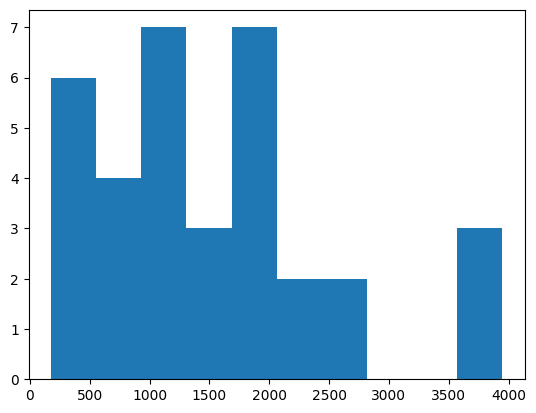

In [3]:
from turbo_chat.utils.tokens import count_tokens

import json
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

scene_lens = [
    count_tokens(
        messages=[dict(role="user", content=json.dumps(scene, indent=2))],
        model="gpt-3.5-turbo",
    )
    for scene in samantha_scenes
]

plt.hist(scene_lens, 10)
plt.show()

In [4]:
from copy import deepcopy
from math import ceil

def chunk_into_n(lst, n):
    size = ceil(len(lst) / n)
    return list(
        map(lambda x: lst[x * size:x * size + size],
        list(range(n)))
    )

split_scenes = []

max_length = 4000

for scene, length in zip(samantha_scenes, scene_lens):
    if length < max_length:
        split_scenes.append(scene)
        continue

    # Split scene
    len_turns = len(scene["turn"])
    num_splits = (length // max_length) + 1
    split_turns = chunk_into_n(scene["turn"], num_splits)
    
    for i in range(num_splits):
        scene_copy = deepcopy(scene)
        scene_copy["turn"] = split_turns[i]

        split_scenes.append(scene_copy)

len(samantha_scenes), len(split_scenes)

(34, 34)

In [5]:
selected_scenes = []

for scene in split_scenes:
    scene_str = json.dumps(scene)
    if (
        "SAMANTHA" in scene_str
        or "FEMALE OS VOICE" in scene_str
    ):
        selected_scenes.append(scene)

len(selected_scenes)

34

In [6]:
scenes = selected_scenes

scenes_with_1turn = [i for i, s in enumerate(scenes) if isinstance(s["turn"], dict)]

for i in scenes_with_1turn:
    scene = scenes[i]
    scene["turn"] = [scene["turn"]]
    
scenes_with_1act = [i for i, s in enumerate(scenes) if s.get("act") and isinstance(s["act"], dict)]

for i in scenes_with_1act:
    scene = scenes[i]
    scene["act"] = [scene["act"]]
    
    
scenes_with_1dlg = [i for i, s in enumerate(scenes) if s.get("dlg") and isinstance(s["dlg"], dict)]

for i in scenes_with_1dlg:
    scene = scenes[i]
    scene["dlg"] = [scene["dlg"]]

In [7]:
processed_scenes = []

for scene in scenes:
    # Extract relevant data
    situation = (
        scene["@heading"]
        .replace("EXT", "Outdoors")
        .replace("INT", "Indoors")
    )
    
    acts = [
        act for act in scene.get("act", [{"$": ""}])
        # if isinstance(act, dict)
        if "pg" not in act["$"].lower()
    ]
    
    acts += [{"$": ""}]
    
    information_top = acts[0]["$"].replace("\n", " ").strip()
    turns = []
    
    for turn in scene["turn"]:
        par = turn.get("par", {"$": ""})
        par = par[0] if isinstance(par, list) else par
        tone = par["$"].replace("(", "").replace(")", "")
        
        char = turn["@char"].strip().upper()
        is_samantha = char in ["SAMANTHA", "FEMALE OS VOICE"]
        is_robot = char == "TEXT VOICE"
        tone = "robotic" if is_robot else tone
        role = "assistant" if is_samantha or is_robot else "user"
        
        name = "Samantha" if is_samantha else char.capitalize()

        turn_acts = turn.get("act", {"$": ""})
        turn_acts = turn_acts if isinstance(turn_acts, list) else [turn_acts]
        turn_acts = [a for a in turn_acts if "pg" not in a["$"].lower()]
        [turn_act, *_] = turn_acts + [{"$": ""}]
        turn_act = turn_act["$"].replace("\n", " ").strip()
        
        turn_dialogs = turn["dlg"]
        turn_dialogs = turn_dialogs if isinstance(turn_dialogs, list) else [turn_dialogs]
        content = "\n".join(map(
            lambda x: x.replace("\n", " "),
            [dlg["$"] if isinstance(dlg, dict) else dlg for dlg in turn_dialogs],
        ))
        
        data = dict(
            tone=tone,
            role=role,
            name=name,
            act=turn_act,
            content=content,
        )
        
        turns.append(data)


    # Add scene data
    processed_scenes.append(dict(
        situation=situation,
        information_top=information_top,
        turns=turns,
    ))

In [8]:
from datasets import Dataset

dataset = Dataset.from_list(processed_scenes)

In [9]:
dataset[0]

{'situation': "Indoors. THEODORE'S HOME OFFICE - NIGHT",
 'information_top': "Theodore sits at his desk that houses a futuristic, large screen computer monitor. The OS box is open, with warranties and paperwork spilling out. He's leafing through the papers. He glances at his monitor, it says: Installation 98% complete. A chime brings his attention back to the screen: Installation Complete.",
 'turns': [{'act': '',
   'content': "Mr. Theodore Twombly, welcome to the world's first artificially intelligent operating system, OS ONE. We'd like to ask you a few basic questions before the operating system is initiated. This will help create an OS to best fit your needs.",
   'name': 'Text voice',
   'role': 'assistant',
   'tone': 'robotic'},
  {'act': '',
   'content': 'Okay.',
   'name': 'Theodore',
   'role': 'user',
   'tone': ''},
  {'act': '',
   'content': 'Are you social or anti-social?',
   'name': 'Text voice',
   'role': 'assistant',
   'tone': 'robotic'},
  {'act': '',
   'content

In [10]:
from datetime import datetime, timedelta
import random
from random import randrange
import re


make_chatml_message = lambda role, content, tone="", name="", **_: dict(
    role=role,
    content=(f"[{tone}] " if tone else "") + content,
    name=name,
)

def transform_to_chatml(scene):
    
    # Container for adding messages
    messages = []
    
    # Add system messages
    messages.append(make_chatml_message(
        role="system",
        name="situation",
        content=scene["situation"],
    ))
    
    if scene.get("information_top"):
        messages.append(make_chatml_message(
            role="system",
            name="information",
            content=scene["information_top"],
        ))

    # Loop through dialog and add chatml messages
    for turn in scene["turns"]:
        if (act := turn.get("act", "")):
            messages.append(make_chatml_message(
                role="system",
                name="information",
                content=act,
            ))

        messages.append(make_chatml_message(**turn))
            
    scene["chatml"] = messages
    
    return scene

In [11]:
dataset = dataset.map(transform_to_chatml)
print(dataset[10]["chatml"])

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

[{'content': 'Indoors. SUBWAY - DAY', 'name': 'situation', 'role': 'system'}, {'content': "Theodore's on the subway. He's got his device in his breast pocket, with the lens facing out.", 'name': 'information', 'role': 'system'}, {'content': 'Do you like this song?', 'name': 'Samantha', 'role': 'assistant'}, {'content': 'Mmm.', 'name': 'Theodore', 'role': 'user'}, {'content': 'The subway comes out of the tunnel and into the light. We are up in the hills looking out over the city as the morning light warms Theodore.', 'name': 'information', 'role': 'system'}, {'content': "I heard it the other day and I can't stop listening to it.", 'name': 'Samantha', 'role': 'assistant'}]


In [12]:
assistant_me_map = {
    "user": "person",
    "assistant": "me",
}

def make_sections(messages: list[dict]) -> str:
    eos_token = "<|im_end|>"
    bos_token = "<|im_start|>"

    result = bos_token + (eos_token+'\n'+bos_token).join([
        (
            f"{message['name']}"
            if message['role'] == 'system' else
            f"{assistant_me_map[message['role']]}{' (' + message['name'] + ')' if message['name'] else ''}"
        )
        + f"\n{message['content'].strip()}"
        for message in messages
    ]) + eos_token
    
    return result
    

def transform_to_samantha_dialog(sample):

    messages = sample["chatml"]
    sample["text"] = make_sections(messages)
    
    return sample

In [13]:
dataset = dataset.map(transform_to_samantha_dialog)
print(dataset[10]["text"])

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

<|im_start|>situation
Indoors. SUBWAY - DAY<|im_end|>
<|im_start|>information
Theodore's on the subway. He's got his device in his breast pocket, with the lens facing out.<|im_end|>
<|im_start|>me (Samantha)
Do you like this song?<|im_end|>
<|im_start|>person (Theodore)
Mmm.<|im_end|>
<|im_start|>information
The subway comes out of the tunnel and into the light. We are up in the hills looking out over the city as the morning light warms Theodore.<|im_end|>
<|im_start|>me (Samantha)
I heard it the other day and I can't stop listening to it.<|im_end|>


In [14]:
dataset.column_names

['situation', 'information_top', 'turns', 'chatml', 'text']

In [15]:
dataset = dataset.remove_columns([
    'turns',
    'situation',
    'information_top',
    'text',
])

dataset.push_to_hub("diwank/samantha-movie-dialog-4k", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]